<h1> Сердечная недостаточность 🫀 - Лабороторная работа 3 <h1>

<h3>Используемые метрики гиперпарамтеры<h3>
<h4>

**Взятые метрики** - Accuracy, ROC AUC

Обе метрики, Accuracy и ROC AUC, полезны для оценки производительности моделей Random Forest. Accuracy предоставляет простое и быстрое понимание правильности предсказаний, в то время как ROC AUC дает более глубокое понимание способности модели различать классы.

**Гиперпараметры**


1. **n_estimators** — это параметр, задающий количество деревьев в "случайном лесу". Большое количество деревьев может повысить точность модели, но также увеличивает время обучения и предсказания. Обычно выбирается с помощью кросс-валидации.

2. **max_features** — этот параметр определяет максимальное количество признаков (переменных), которое будет использоваться для поиска наилучшего разбиения в каждом узле дерева. 

3. **max_depth** — максимальная глубина каждого дерева. Ограничение глубины помогает предотвратить переобучение, т.е. когда модель становится слишком сложной и начинает подстраиваться под шум в данных. Позволяет контролировать сложность дерева.

4. **min_samples_split** — минимальное количество объектов в узле, необходимое для его расщепления. Это означает, что если в узле меньше объектов, чем указано, расщепление не будет происходить. Установка этого параметра помогает предотвратить создание слишком маленьких узлов и переобучение.

5. **min_samples_leaf** — минимальное количество объектов, которые должны быть в листьях дерева. Этот гиперпараметр также способствует снижению переобучения, так как гарантирует, что листья содержат достаточное количество данных, делая модель более стабильной.

6. **bootstrap** — этот параметр указывает, следует ли использовать подвыборки с возвращением при обучении каждого дерева. Если **True**, то для каждого дерева в лесу создается новая выборка путем случайной выборки данных с возвращением, что может повысить устойчивость модели.
<h4>

<h3>Библиотеки<h3>

In [184]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap 
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler

from sklearn.datasets import load_breast_cancer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor


<h3> Константы <h3>

In [185]:
RANDOM_STATE = 42
PATH = 'heart.csv'

<h3>Предпросмотр данных<h3>

In [186]:
data = pd.read_csv(PATH)
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<h3>Просмотр дублирующих значений<h3>

In [187]:
missing_values = data.isnull().sum()
duplicates = data.duplicated().sum()

missing_values, duplicates

(age         0
 sex         0
 cp          0
 trtbps      0
 chol        0
 fbs         0
 restecg     0
 thalachh    0
 exng        0
 oldpeak     0
 slp         0
 caa         0
 thall       0
 output      0
 dtype: int64,
 np.int64(1))

<h3>Удаление дубликатов<h3>

In [188]:
data = data.drop_duplicates()

<h3> Деление на признаки и выборки <h3>

In [189]:
X = data.drop(columns=['output'])
y = data['output']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=(RANDOM_STATE), stratify=y)
X_train.shape, X_test.shape

((241, 13), (61, 13))

<h2> Random Forest <h2>

In [190]:
model = RandomForestClassifier(random_state=RANDOM_STATE)

In [191]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 3, 4]
    
}

<h3>Подбор гиперпараметров<h3>

In [192]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [193]:
gsf = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


<h3> Вывод наилучших гиперпараметров<h3>

In [194]:
(gsf.best_params_, gsf.best_score_)

({'max_depth': None,
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'n_estimators': 200},
 np.float64(0.9148148148148149))

<h3>Использование ML-модели и кросс-валидации с scikit-learn методами<h3>

In [195]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    clf = RandomForestClassifier(**param, random_state=RANDOM_STATE)
    
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

In [196]:
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=50)

(study.best_params, study.best_value)

[I 2024-12-21 01:53:03,883] A new study created in memory with name: no-name-8fa57d03-7f1d-4263-93e0-ae1149812b31
[I 2024-12-21 01:53:05,039] Trial 0 finished with value: 0.9130795130795131 and parameters: {'n_estimators': 437, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 12, 'bootstrap': True}. Best is trial 0 with value: 0.9130795130795131.
[I 2024-12-21 01:53:05,337] Trial 1 finished with value: 0.9116679616679617 and parameters: {'n_estimators': 152, 'max_depth': 44, 'min_samples_split': 13, 'min_samples_leaf': 15, 'bootstrap': False}. Best is trial 0 with value: 0.9130795130795131.
[I 2024-12-21 01:53:07,139] Trial 2 finished with value: 0.9053872053872054 and parameters: {'n_estimators': 850, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 0 with value: 0.9130795130795131.
[I 2024-12-21 01:53:08,128] Trial 3 finished with value: 0.9074721574721574 and parameters: {'n_estimators': 489, 'max_depth': 18, 'min_sample

({'n_estimators': 282,
  'max_depth': 5,
  'min_samples_split': 10,
  'min_samples_leaf': 7,
  'bootstrap': True},
 0.9186609686609687)

In [197]:
default_params = RandomForestRegressor(RANDOM_STATE).get_params()

for pram, value in study.best_trial.params.items():
    print(f'{pram}: chosen: {value}, default: {default_params[pram]}')

n_estimators: chosen: 282, default: 42
max_depth: chosen: 5, default: None
min_samples_split: chosen: 10, default: 2
min_samples_leaf: chosen: 7, default: 1
bootstrap: chosen: True, default: True


<h3>Вывод<h3>
<h5>

| Параметр             | Выбор (chosen) | По умолчанию (default) | Описание                                                                    |
|----------------------|----------------|------------------------|-----------------------------------------------------------------------------|
| n_estimators    | 282            | 42                     | Увеличение числа деревьев для улучшения модели и уменьшения смещения. Это повышает вычислительные затраты. |
| max_depth        | 5              | None                   | Ограничение глубины дерева для снижения переобучаемости.                     |
| min_samples_split| 10             | 2                      | Увеличение минимального количества образцов для разделения узла до 10, что может привести к более обобщающим узлам. |
| min_samples_leaf | 7              | 1                      | Увеличение минимального количества образцов в листе до 7 для повышения устойчивости деревьев. |
| bootstrap        | True           | True                   | Использование метода подвыборок (bagging) остается включенным, что является стандартной практикой для улучшения модели. |

<h5>


<h3> Обучение RandomForestClassifier с оптимальными гиперпараметрами <h3>

In [198]:
best_params = study.best_params
best_model = RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=7, min_samples_split=10,
                       n_estimators=282, random_state=42)

<h3>Сравнение модели со стандартными и оптимальными гиперпараметрами<h3>

In [199]:
default_params = RandomForestClassifier(RANDOM_STATE)
best_params = RandomForestClassifier(**best_params, random_state=RANDOM_STATE)

default_params.fit(X_train, y_train)
best_params.fit(X_train,y_train)


RandomForestClassifier(max_depth=5, min_samples_leaf=7, min_samples_split=10,
                       n_estimators=282, random_state=42)

In [200]:
y_pred_best = best_params.predict(X_test)
y_pred_proba_best = best_params.predict_proba(X_test)[:, 1]

y_pred_default = default_params.predict(X_test)
y_pred_proba_defalut = default_params.predict_proba(X_test)[:, 1]

accuracy_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)

accuracy_default = accuracy_score(y_test, y_pred_default)
roc_auc_default = roc_auc_score(y_test, y_pred_proba_defalut)

print(f"Accuracy best: {accuracy_best:.4f}; Accuracy default: {accuracy_default:.4f}; Разница {accuracy_best - accuracy_default:.4f}")
print(f"ROC AUC best: {roc_auc_best:.4f}; ROC AUC default: {roc_auc_default:.4f}; Разница {roc_auc_best - roc_auc_default:.4f}")

Accuracy best: 0.8033; Accuracy default: 0.8197; Разница -0.0164
ROC AUC best: 0.9004; ROC AUC default: 0.9058; Разница -0.0054


<h3>Permutation Importance<h3>

In [201]:
perm_importance = permutation_importance(
    best_model, X_test, y_test, scoring="roc_auc", n_repeats=10, random_state=RANDOM_STATE
)

sorted_idx = perm_importance.importances_mean.argsort()

<h3>Визуализация Permutation Importance<h3>

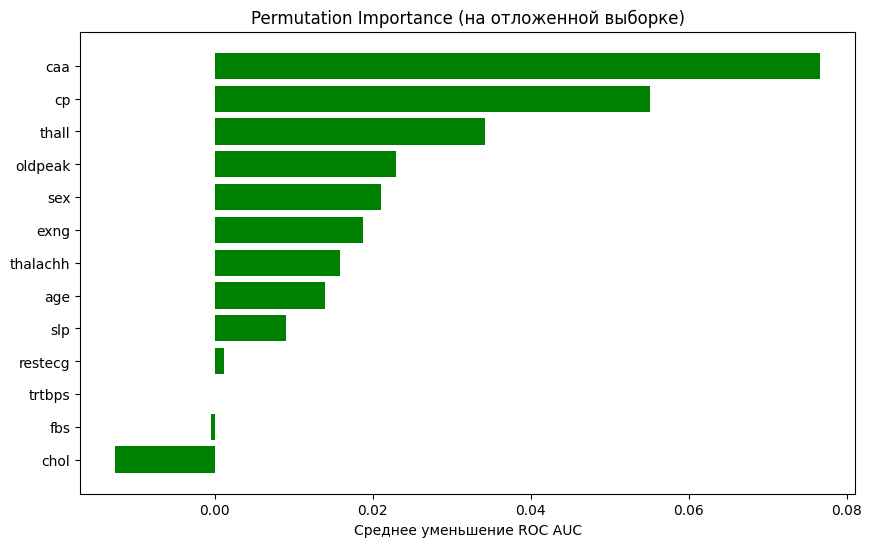

In [202]:
plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], color="green")
plt.xlabel("Среднее уменьшение ROC AUC")
plt.title("Permutation Importance (на отложенной выборке)")
plt.show()

<h3>Выводы<h3>
<h4>

**Для модели играют большую роль переменные caa, cp и thall, а также oldpeak и sex**

1. **Наиболее важные переменные:** Переменные caa, cp и thall оказывают наибольшее влияние на модель, так как они показали наибольшее уменьшение ROC AUC при их изменении.


2. **Средняя важность:** Переменные oldpeak и sex также значимы, но в меньшей степени по сравнению с вышеупомянутыми.


3. **Менее важные переменные:** Переменные restecg, trtbps, fbs и chol имеют наименьшее влияние на модель, что может говорить о том, что они содержат меньше информации для предсказания в данной задаче.

<h4>

<h3>Shap<h3>

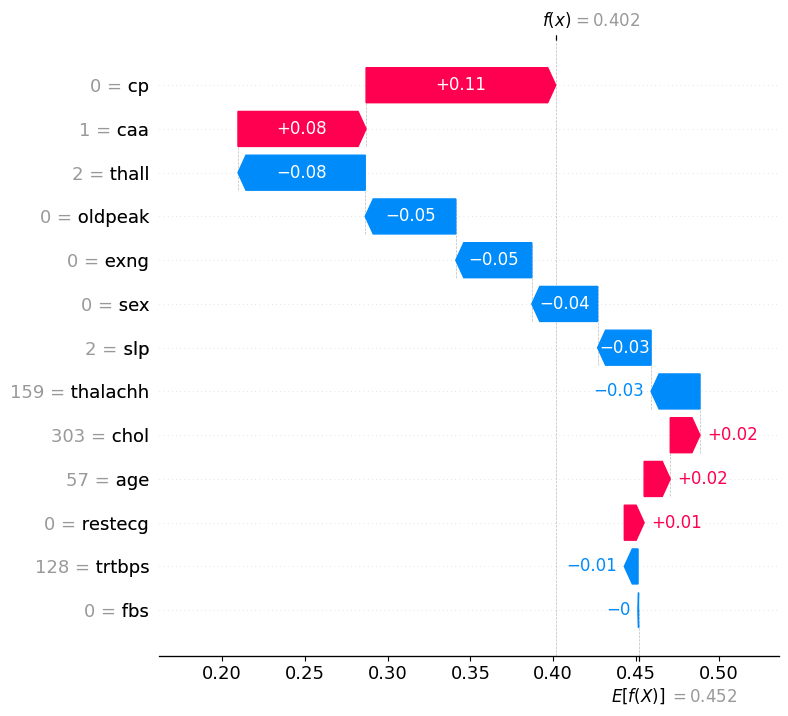

In [206]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)


shap.plots.waterfall(shap_values[0,:, 0], max_display=13) #измерение строчки предсказания [0,..]

**Вывод по shap:**


- cp (боль в груди): Этот признак увеличивает предсказание на 0.11.
- caa (количество главных сосудов): Увеличивает предсказание на 0.08.
- thall (талассемия): Уменьшает предсказание на 0.08.
- oldpeak (депрессия ST): Уменьшает на 0.05.
- exng (упражнения индуцируют стенокардию): Уменьшает на 0.05.
- sex (пол): Уменьшает на 0.04.

Вклад остальных признаков (slp, thalachh, chol, age, restecg, trtbps, fbs) незначителен и колеблется в пределах -0.03 до +0.02.

Итоговое предсказание модели составляет 0.402, в то время как среднее значение составляет 0.452. Это означает, что суммарное влияние признаков уменьшило итоговое предсказание ниже среднего уровня.
